# Разработка стратегии взаимодействия с клиентами фитнес-центра по сокращению оттока клиентов 

## Цель
Для борьбы с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача — провести анализ и подготовить план действий по удержанию клиентов.
    <ul>
    <li> научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;</li>
    <li> сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;</li>
    <li> проанализировать основные признаки, наиболее сильно влияющие на отток;</li>
    <li> сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:</li>
        <ul>
            <li> 1) выделить целевые группы клиентов;</li>
            <li> 2) предложить меры по снижению оттока;</li>
            <li> 3) определить другие особенности взаимодействия с клиентами.</li>
        </ul>
    </ul>

## Шаг 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math as mth
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools

In [2]:
# Загрузска данных
path_file = 'input/'
df = pd.read_csv(path_file+'prj_12_gym_churn.csv')

In [3]:
df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Описание данных 
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
* `Churn` — факт оттока в текущем месяце.

In [4]:
# получение общей информации о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Изменим стиль написания названия колонок

In [5]:
# Изменение стиля написания названий колонок
df.columns= df.columns.str.lower()

In [6]:
# посмотрим на названия колонок после изменения
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Выводы: в таблице с данными имеется 4000 записей. В 14 колонках содержатся характеристики каждого клиента. Пропусков нет.

## Шаг 2. Исследовательский анализ данных (EDA)

Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения (пригодится метод describe());

Из описания общей информации в таблице видно, что в таблице имеется 4000 записи. Отсутствующих данных нет.

Проверим есть ли дубликаты

In [7]:
# проверка на отсутствие дубликатов в orders
print(f'Количество дубликатов в таблице {df.duplicated().sum()}')

Количество дубликатов в таблице 0


In [8]:
# Функция для анализа данных в колонках
def data_analysis(column_name):
    print()
    print('-'*40)
    print(f'Анализ данных в колонке {column_name}')
    print('-'*40)
    print(f'Тип данных в колонке: {df[column_name].dtype}')
    data_0 = len(df[df[column_name].isnull()==True])
    print(f'Количество отсутствующих значений в столбце: {data_0}')
    print(f'Процент отсутствующих значений: {data_0/len(df):.1%}')
    print(f'Число уникальных данных: {len(df[column_name].unique())}')
    if len(df[column_name].unique()) < 40:
        print(f'Уникальные значения: {df[column_name].unique()}')
        if len(df[column_name].unique()) < 4:
            print('Количество данных по группам уникальных значений:')
            print(df.groupby([column_name])[column_name].count())
    else:
        print('Число уникальных значений слишком велико для вывода')
        
    print('Описание данных в колонке:')
    display(df[column_name].describe()) 

Изучим данные в каждой колонке

In [9]:
# изучим данные в колонке 'gender'
data_analysis('gender')


----------------------------------------
Анализ данных в колонке gender
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
gender
0    1959
1    2041
Name: gender, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

Количество данных в таблице для каждого пола практически одинаковое.

In [10]:
# изучим данные в колонке 'near_location'
data_analysis('near_location')


----------------------------------------
Анализ данных в колонке near_location
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
near_location
0     619
1    3381
Name: near_location, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: near_location, dtype: float64

Количество клиентов, проживающих или работающих по близости к фитнес-центру, значительно превышает количество клиентов "не из района" фитнес-центра (при предположении, что "1" - обозначает клиентов из района финтес-центра).

In [11]:
# изучим данные в колонке 'partner'
data_analysis('partner')


----------------------------------------
Анализ данных в колонке partner
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
partner
0    2053
1    1947
Name: partner, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: partner, dtype: float64

Количество клиентов, являющимися сотрудниками компаний-партнёров клуба, практически столько же, сколько клиентов "не партнеров"

In [12]:
# изучим данные в колонке 'promo_friends'
data_analysis('promo_friends')


----------------------------------------
Анализ данных в колонке promo_friends
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
promo_friends
0    2766
1    1234
Name: promo_friends, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: promo_friends, dtype: float64

Количество данных категории "1" колонки 'promo_friends', составляет примерно треть от всех данных.
Если предположить, что "1" - пришел по акции, а "0" - без акции, то большинство клиентов пришло в клуб без акции.

In [13]:
# изучим данные в колонке 'phone'
data_analysis('phone')


----------------------------------------
Анализ данных в колонке phone
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [0 1]
Количество данных по группам уникальных значений:
phone
0     386
1    3614
Name: phone, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: phone, dtype: float64

Более 75% клиентов оставляет номер телефона

In [14]:
# изучим данные в колонке 'contract_period'
data_analysis('contract_period')


----------------------------------------
Анализ данных в колонке contract_period
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 3
Уникальные значения: [ 6 12  1]
Количество данных по группам уникальных значений:
contract_period
1     2207
6      833
12     960
Name: contract_period, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        4.681250
std         4.549706
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: contract_period, dtype: float64

Более половины записей соответствуют клиентам с абониментом на месяц.

In [15]:
# изучим данные в колонке 'group_visits'
data_analysis('group_visits')


----------------------------------------
Анализ данных в колонке group_visits
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [1 0]
Количество данных по группам уникальных значений:
group_visits
0    2351
1    1649
Name: group_visits, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.412250
std         0.492301
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: group_visits, dtype: float64

Более 50% клиентов не посещают групповые занятия (при предположении, что "0" - не посещает групповые занятия, а "1"- посещает)

In [16]:
# изучим данные в колонке 'age'
data_analysis('age')


----------------------------------------
Анализ данных в колонке age
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 23
Уникальные значения: [29 31 28 33 26 34 32 30 23 27 35 25 36 24 21 37 22 19 20 38 39 18 41]
Описание данных в колонке:


count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

Средний возраст клиентов - 29 лет

In [17]:
# изучим данные в колонке 'avg_additional_charges_total'
data_analysis('avg_additional_charges_total')


----------------------------------------
Анализ данных в колонке avg_additional_charges_total
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 4000
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

В среднем, клиенты дополнительно тратят 136 у.ед. 75% посетителей тратят не более 211 у.ед. 

In [18]:
# изучим данные в колонке 'month_to_end_contract'
data_analysis('month_to_end_contract')


----------------------------------------
Анализ данных в колонке month_to_end_contract
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 12
Уникальные значения: [ 5. 12.  1.  6.  3. 10. 11.  9.  4.  7.  8.  2.]
Описание данных в колонке:


count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64

Здесь аномалий не наблюдается: ранее, мы уже видели, что более половины посетителей фитнес-центра имеют контракт на месяц. Здесь мы видим тоже самое - у половины клиентов контрак закончится через месяц

In [19]:
# изучим данные в колонке 'lifetime'
data_analysis('lifetime')


----------------------------------------
Анализ данных в колонке lifetime
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 29
Уникальные значения: [ 3  7  2  0  1 11  4  8 14  6  5 15 12 21 10 20  9 13 17 16 24 22 31 26
 23 18 19 27 29]
Описание данных в колонке:


count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: lifetime, dtype: float64

В среденем, время с момента первого обращения в фитенс-центр составляет практически 4 месяца. Медианное значение равно 3 месяцам. 75% клиентов являются клиентами не более 5 месяцев.

In [20]:
# изучим данные в колонке 'avg_class_frequency_total'
data_analysis('avg_class_frequency_total')


----------------------------------------
Анализ данных в колонке avg_class_frequency_total
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 3913
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: avg_class_frequency_total, dtype: float64

В среднем, клиенты посещают в неделю фитенс-центр не более 2-х раз в неделю.

In [21]:
# изучим данные в колонке 'avg_class_frequency_current_month'
data_analysis('avg_class_frequency_current_month')


----------------------------------------
Анализ данных в колонке avg_class_frequency_current_month
----------------------------------------
Тип данных в колонке: float64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 3820
Число уникальных значений слишком велико для вывода
Описание данных в колонке:


count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: avg_class_frequency_current_month, dtype: float64

Среденее посещение за предыдущий месяц для 75% клиентов ниже, чем тот же критерий за все время посещение фитнес-центра.

In [22]:
# изучим данные в колонке 'churn'
data_analysis('churn')


----------------------------------------
Анализ данных в колонке churn
----------------------------------------
Тип данных в колонке: int64
Количество отсутствующих значений в столбце: 0
Процент отсутствующих значений: 0.0%
Число уникальных данных: 2
Уникальные значения: [0 1]
Количество данных по группам уникальных значений:
churn
0    2939
1    1061
Name: churn, dtype: int64
Описание данных в колонке:


count    4000.000000
mean        0.265250
std         0.441521
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: churn, dtype: float64

В текущем месяце треть клиентов ушла (при предположении, что "1" - клиент ушел)

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток ("1") и тех, кто остался ("0").

In [23]:
df.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Видно, что пол не является показателем оттока (оба пола одинаково себя ведут). Так же, в среднем, в каждой группе клиенты в основном оставляют свой номер телефона. А по остальным категориям проглядывается более явное отличие.  

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

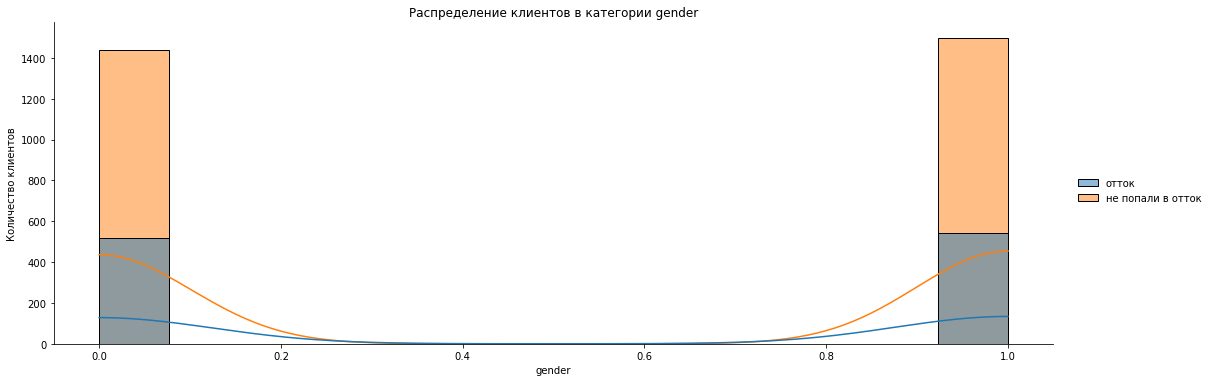

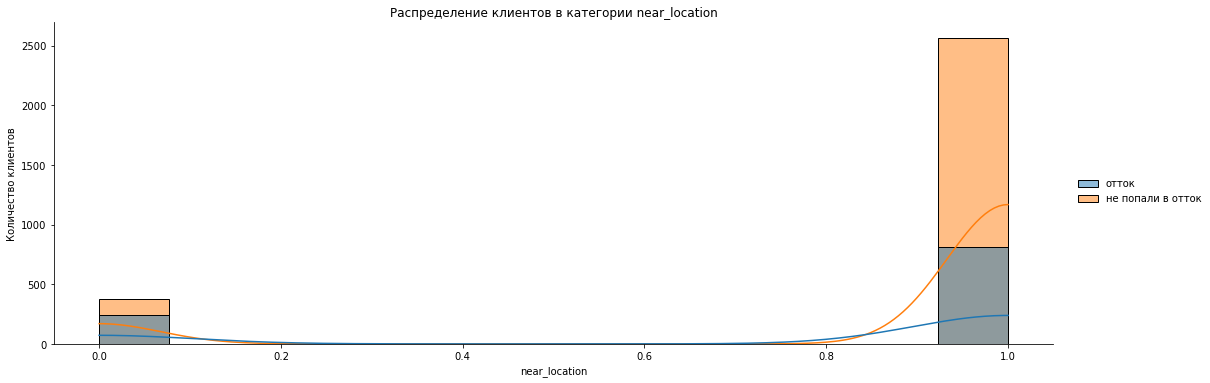

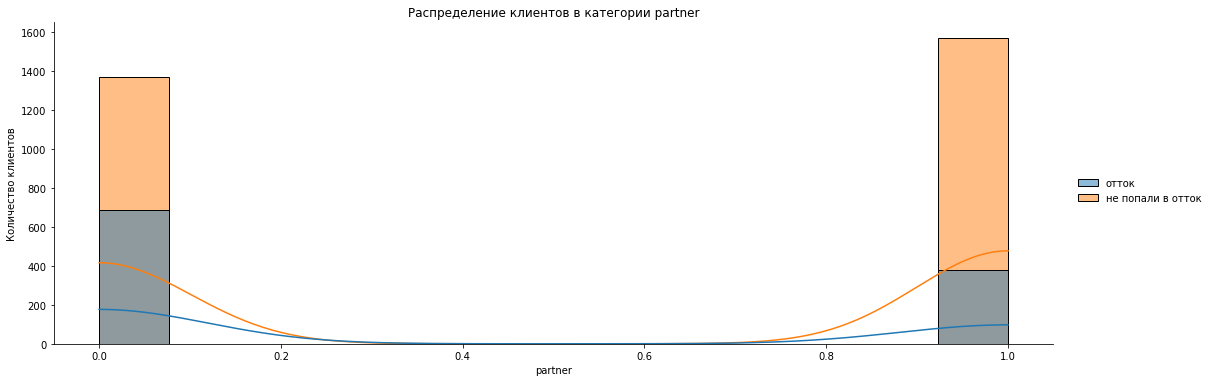

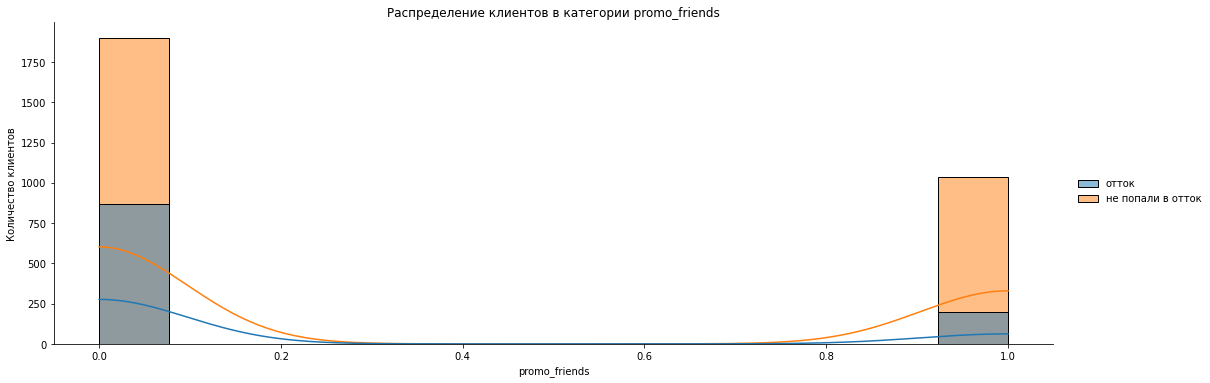

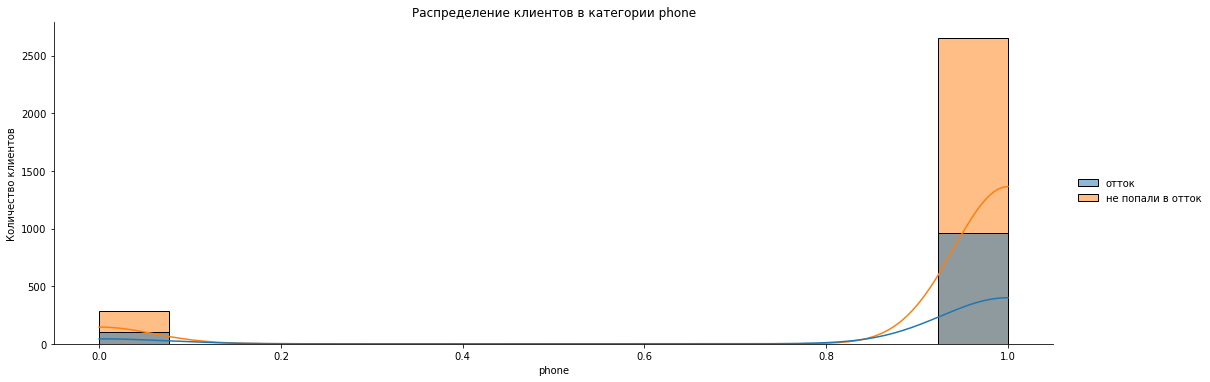

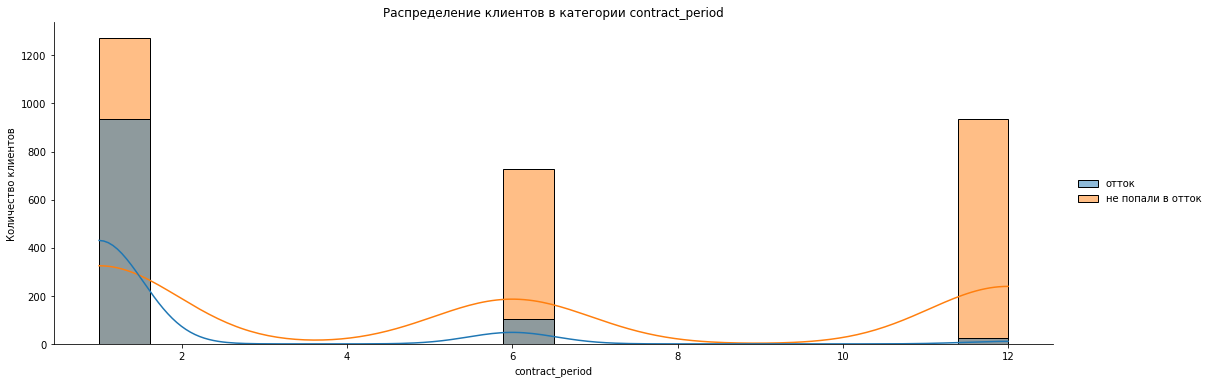

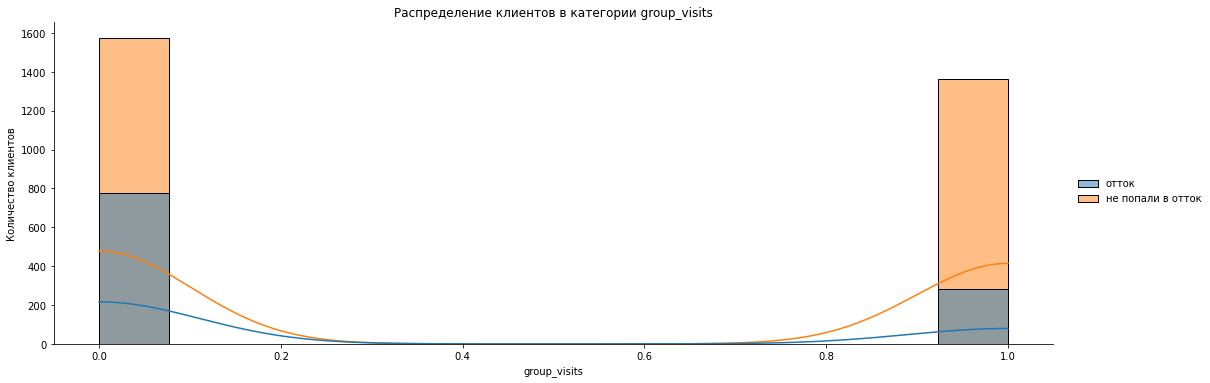

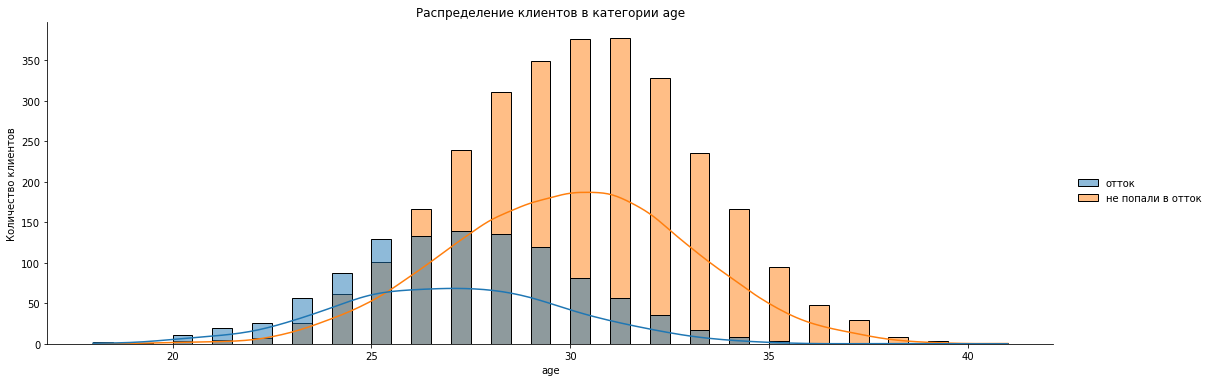

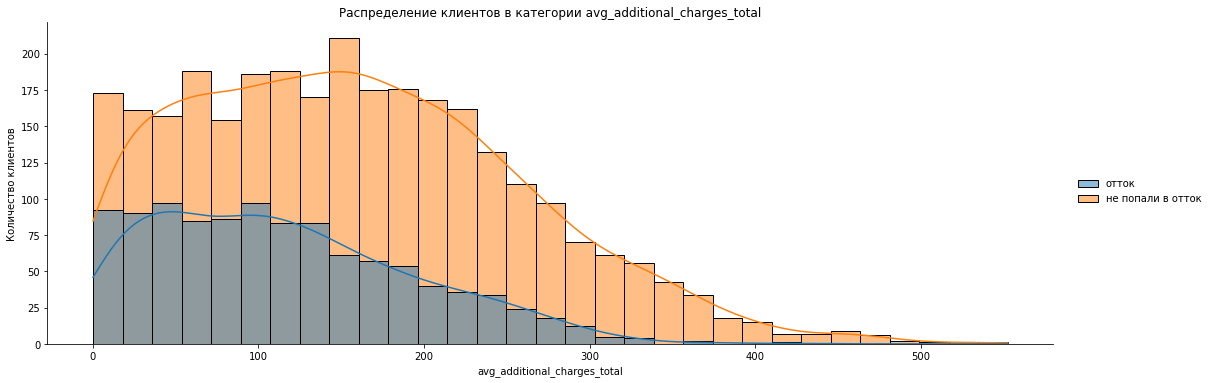

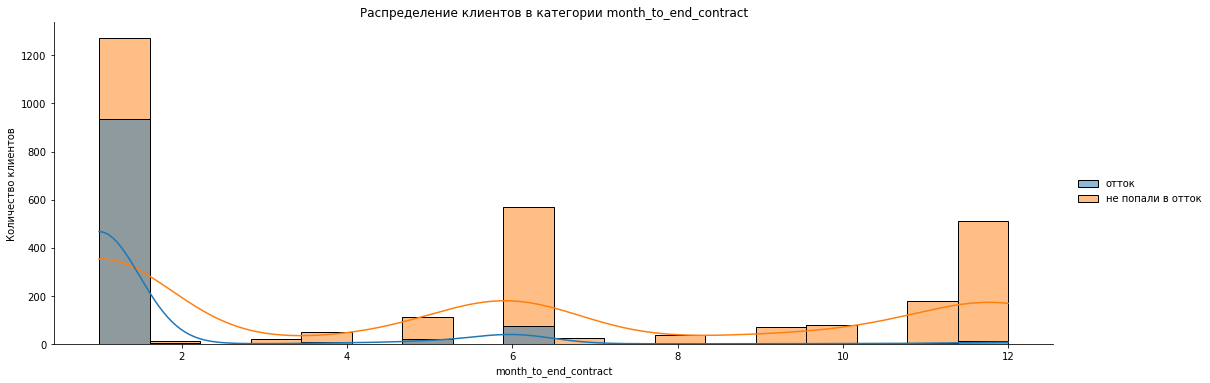

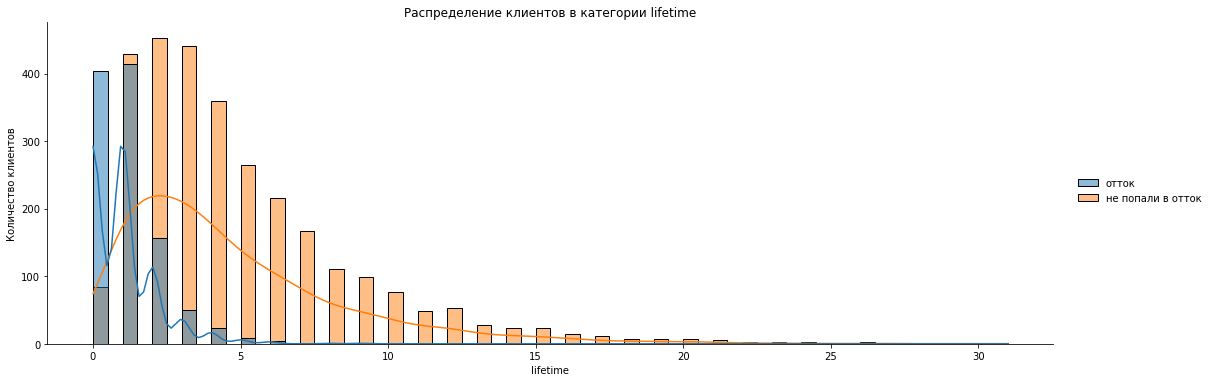

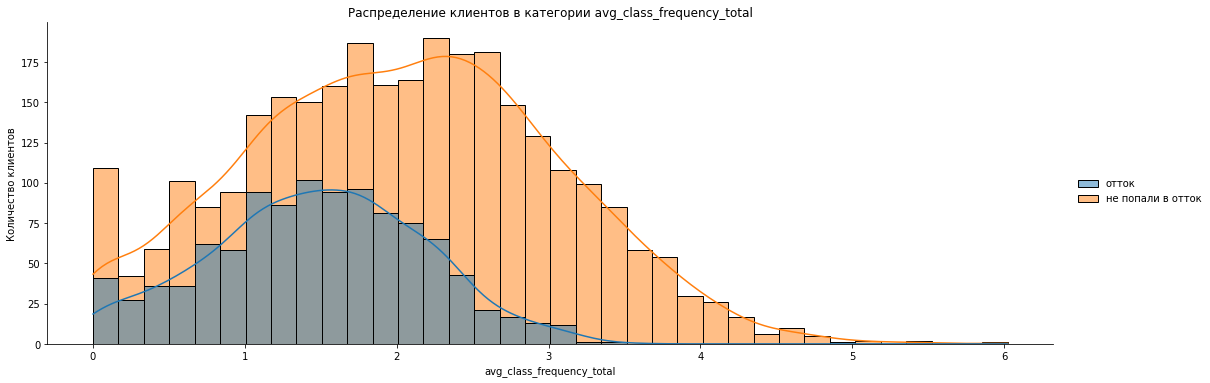

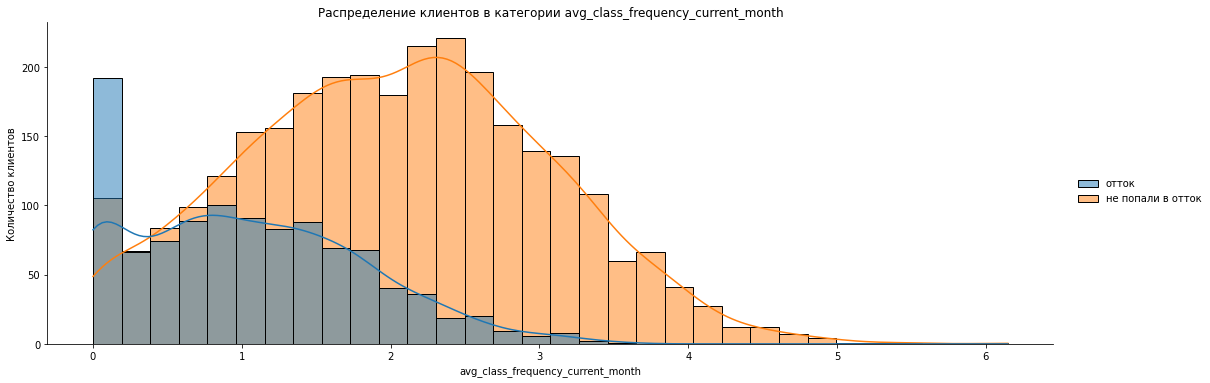

In [24]:
# Построим графики в цикле
for col in range(len(df.columns)-1):
    kat = list(df.columns)[col]
    sns.displot(
        data={
            "отток": df[df.churn == 1][kat],
            "не попали в отток": df[df.churn == 0][kat]
        },height=5, aspect=15/5,kde=True)
    plt.title(f'Распределение клиентов в категории {kat}')
    plt.xlabel(kat)
    plt.ylabel('Количество клиентов');

Теперь построим матрицу корреляций:

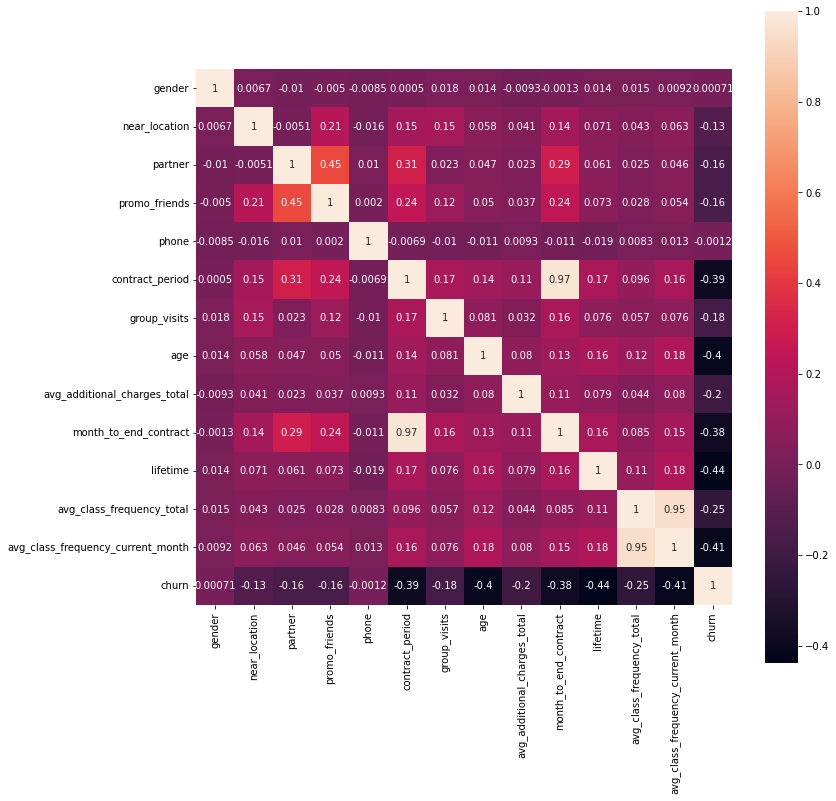

In [25]:
#построим и отрисуем матрицу корреляций
cm = df.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(12,12))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, square=True)
plt.show()

Выводы: 
<li>gender (пол) - не харктеризует отток; корреляция с оттоком слабая - эту характеристику можно исключить для дальнейшего анализа.</li>
<li>near_location - расположение фитнес-центра влияет на отток; оставим эту характеристику для дальнейшего анализа.</li>
<li>partner - "партнеры" реже уходят из фитнес-центра; оставим эту характеристику для дальнейшего анализа</li>
<li>promo_friends - большинство клиентов, пришедших по акции, реже попдают в отток, чем клиенты, пришедшие без акции; оставим эту характеристику для дальнейшего анализа</li>
<li>phone - не выраженно влияет на факт отток клиента. Корреляция с оттоком очень слабаяю. Исключим эту характеристику для дальнейшего анализа.</li>
<li>contract_period - здесь прослеживается явная зависимость: частота оттока значительно выше среди клиентов, заключивших контракт на месяц, чем среди клиентов, заключивших контракт на 6 и 12 месяцев. Эта характеристика очень сильно коррелирует с характеристикой "month_to_end_contract". Характеристику "contract_period" оставим для дальнейшего анализа, а "month_to_end_contract" - исключим.</li>
<li>group_visits - клиенты, на записавшиеся на групповые занятия, чаще попадают в отток. Оставим эту характеристику для дальнейшего анализа.</li>
<li>age - возраст клиента является показателем оттока - чем моложе клиет, тем чаще он попадает в отток; оставим эту характеристику для дальнейшего анализа</li>
<li>avg_additional_charges_total - распределение данных для этой категории очень похоже для тех кто попал в отток и тех кто не попал. Однако, те кто не попал в отток, в среднем тратят на дополнительные услуги больше, чем те, кто попал в отток; оставим эту характеристику для дальнейшего анализа</li>
<li>month_to_end_contract - эта характеристика дублирует характеристику "contract_period"; исключим эту характеристику для дальнейшего анализа.</li>
<li>lifetime - чем больше месяцев человек является клиентом фитнес-центра, тем реже он попадает в отток; эта характеристика имеет хорошую корреляцию с оттоком. Оставим ее для дальнейшего анализа.</li>
<li>avg_class_frequency_total - клиенты, которые не попали в отток чаще посещают фитнес-центр, чем те, кто попал в отток; эта характеристика очень сильно коррелирует с "avg_class_frequency_current_month", но, т.к, "avg_class_frequency_current_month" имеет более сильную корреляцию с оттоком, то исключим из дальнейшего анализа характеристику "avg_class_frequency_total".</li>
<li>avg_class_frequency_current_month - большая часть клиентов, посещающих фитнес-центр 1 раз в неделю (за поледний месяц), попадают в отток. Оставим эту характеристику для дальнейшего анализа.</li>

Создадим датасет для дальнейшего анализа: удалим столбцы 'gender', 'phone', 'month_to_end_contract', 'avg_class_frequency_total'

In [26]:
# Иключим столбцы
df_w = df.drop(columns=['gender', 'phone', 'month_to_end_contract', 'avg_class_frequency_total'])

In [27]:
# Размер датасета 
df_w.shape

(4000, 10)

In [28]:
# посмотрим первые 3 строки нового датасета
df_w.head(3)

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,6,1,29,14.227470,3,0.000000,0
1,1,0,0,12,1,31,113.202938,7,1.910244,0
2,1,1,0,1,0,28,129.448479,2,1.736502,0


## Шаг 3. Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

Разбьём данные на обучающую и валидационную выборку функцией:

In [29]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_w.drop('churn', axis=1)
y = df_w['churn']

In [30]:
#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами:
<li>логистической регрессией (sklearn.linear_model.LogisticRegression())</li>
<li>случайным лесом (sklearn.ensemble.RandomForestClassifier()). </li>

Так как в таблице представлено не равное количество данных для тех кто попал в отток (одна треть данных) и тех кто остался (две третьих), то установим порог для корректировки предсказанного значения в 0.4 

In [31]:
# задим порог
threshold = 0.4

Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели.

In [32]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred, average='binary',zero_division=0)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred, average='binary',zero_division=0)))

In [33]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [34]:
# Преобразуем обучающие и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [35]:
# зададим алгоритм для модели логистической регрессии
lgr_model = LogisticRegression(random_state=0)

In [36]:
# обучим модель
lgr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [37]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lgr_predictions = lgr_model.predict(X_test_st)
lgr_probabilities = lgr_model.predict_proba(X_test_st )[:, 1]

In [38]:
# на основании вероятностей и соотношения классов рассчитаем predict
custom_predictions = [0 if i < threshold else 1 for i in lgr_probabilities]

In [39]:
# выведем все метрики
print_all_metrics(
    y_test,
    custom_predictions,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.78
	Recall: 0.86


In [40]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0) 

In [41]:
# обучим модель случайного леса
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [42]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [43]:
# на основании вероятностей и соотношения классов рассчитаем rf_predictions
custom_predictions_rf = [0 if i < threshold else 1 for i in rf_probabilities]

In [44]:
print_all_metrics(
    y_test,
    custom_predictions_rf,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.77
	Recall: 0.86


Выводы: 
<li>accuracy - обе модели имеют высокую точность, но модель логистической регрессии имеет более высокую точность: 0.91.</li>
<li>precision (доля правильных ответов только среди целевого класса) - модель логистической регрессии имеет более высокую точность: 0.78 против 0.77 случайного леса</li>
<li>recall (сколько реальных объектов "1" класса смогли обнаружить с помощью модели)- это значение у обоих моделей одинаковое: 0.86.</li>
    Таким образом, модель логистической регрессии показывает более высокую точность, чем модель случайного леса.

## Шаг 4. Кластеризация клиентов

Стандартизизуем данные. Предварительно исключим колонку churn из таблицы df_w.

In [45]:
#исключим колонку churn из таблицы
df_w_cat = df_w.drop('churn', axis=1)

In [46]:
# посмотрим на первые строки таблицы
df_w_cat.head(3)

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month
0,1,1,1,6,1,29,14.227470,3,0.000000
1,1,0,0,12,1,31,113.202938,7,1.910244
2,1,1,0,1,0,28,129.448479,2,1.736502


In [47]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(df_w_cat)

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков.

In [48]:
linked = linkage(X_sc, method = 'ward')

Построим дендрограмму

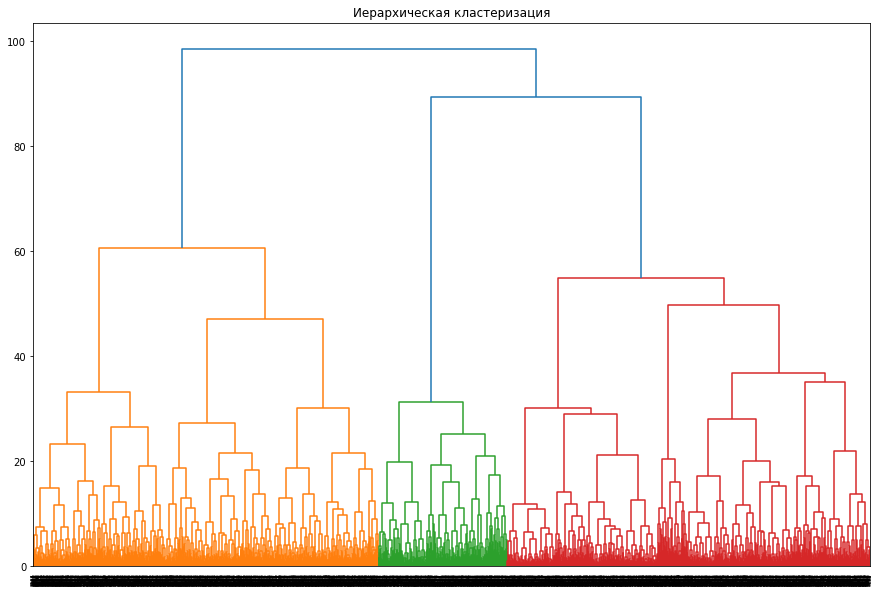

In [49]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Предложенное оптимальное число кластеров самой программой 3 — три разных цветов на графике. Однако, если мы нарисуем горизонтальную линию, которая проходит через самое длинное расстояние (в самой нижней позиции) без горизонтальной линии, мы получим 10 кластеров, как показано на следующем рисунке. Если поднять красную пунктирную линию выше, то можно уменьшить количество выделяемых кластеров и выделить только 5 кластеров.

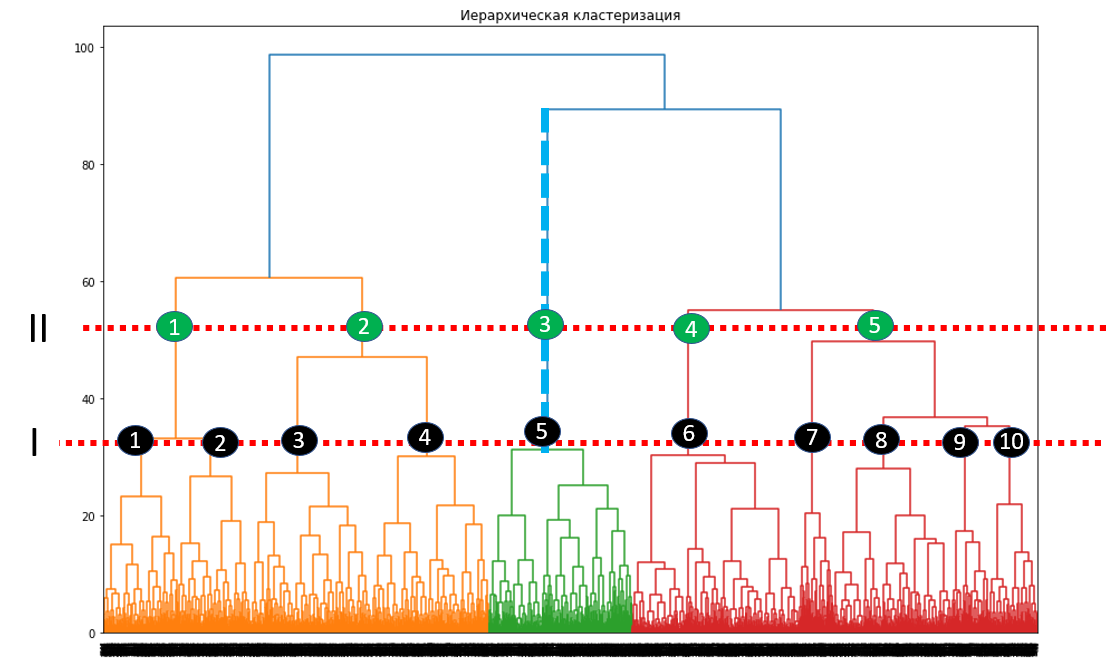

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Примем за число кластеров n=5.

In [50]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

In [51]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [52]:
# сохраняем метки кластера в поле нашего датасета
df_w['cluster_km'] = labels

Посмотрим на средние значения признаков для кластеров

In [53]:
# выводим статистику по средним значениям наших признаков по кластеру
df_w.groupby(['cluster_km']).mean()

,near_location,partner,promo_friends,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,
0,0.000000,0.490099,0.074257,2.942244,0.227723,28.693069,136.983665,2.905941,1.596594,0.404290
1,1.000000,0.147472,0.098315,2.814607,1.000000,29.155899,140.531963,2.771067,1.679171,0.273876
2,0.996071,0.949902,1.000000,7.137525,0.512770,29.513752,151.992438,4.029470,1.884991,0.133595
3,1.000000,0.198990,0.069697,2.022222,0.000000,28.230303,134.391724,2.338384,1.429404,0.484848
4,0.986647,0.565282,0.047478,8.412463,0.410979,30.559347,173.483596,7.044510,2.330966,0.007418


По данной таблице можно сделать вывод, что последний кластер (4) хорошо описал клиента, который с большой вероятностью не попадет в отток: живет или работает рядом, продолжительный контракт, давно ходит, тратит на дополнительные услуги больше, чем среднее значение трат всех клиентов, минимум 2 раза посещает в неделю фитнес-центер. Другие кластеры скорее описывают клиента, который может попасть в отток.

Построим распределения признаков для кластеров

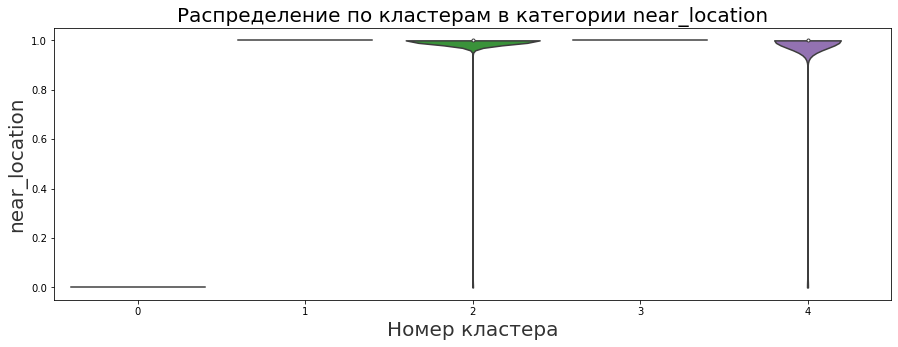

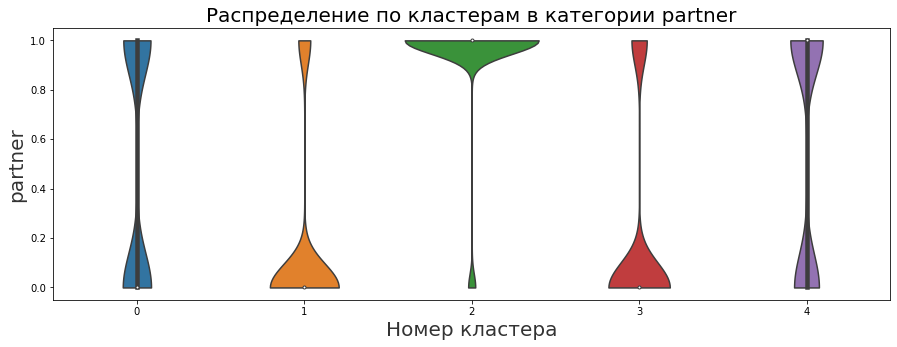

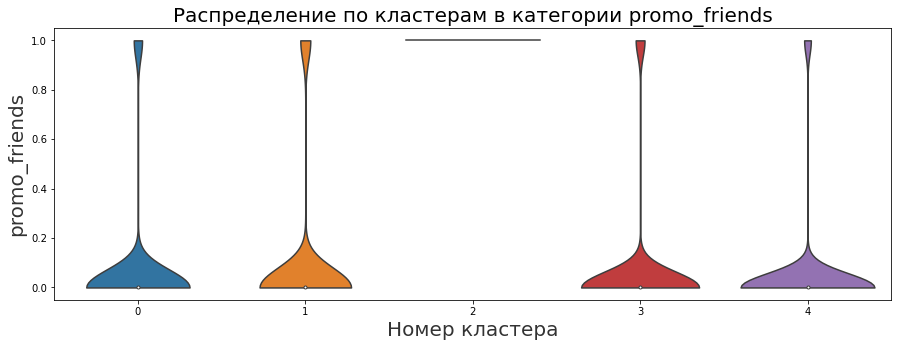

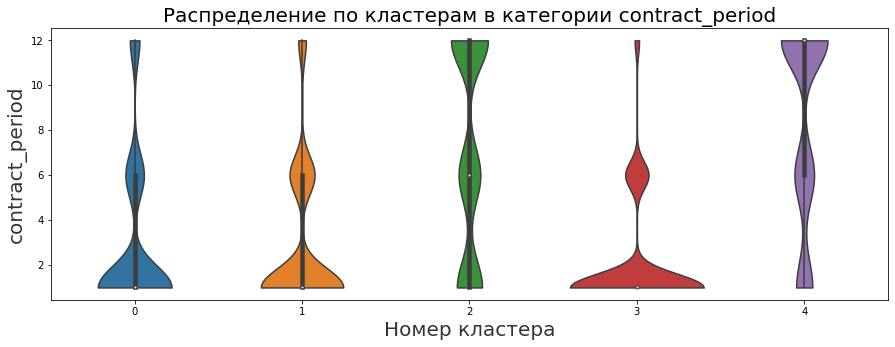

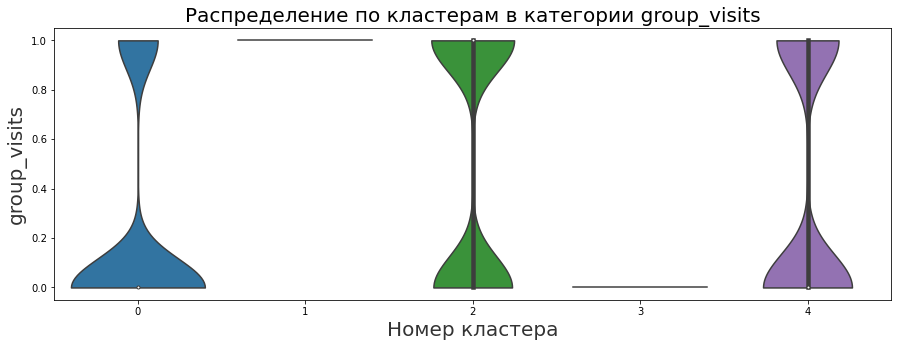

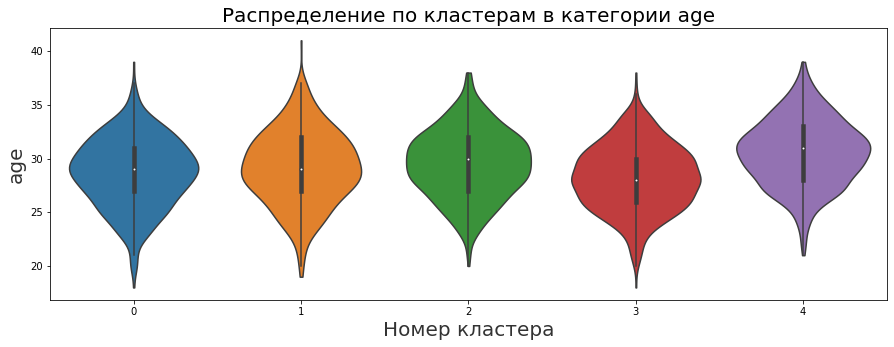

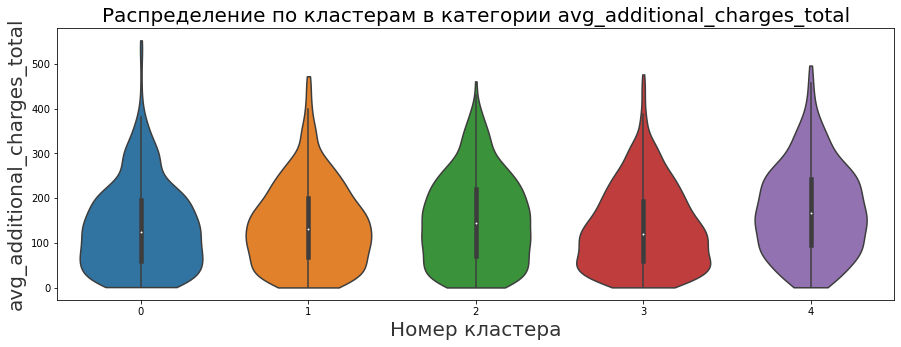

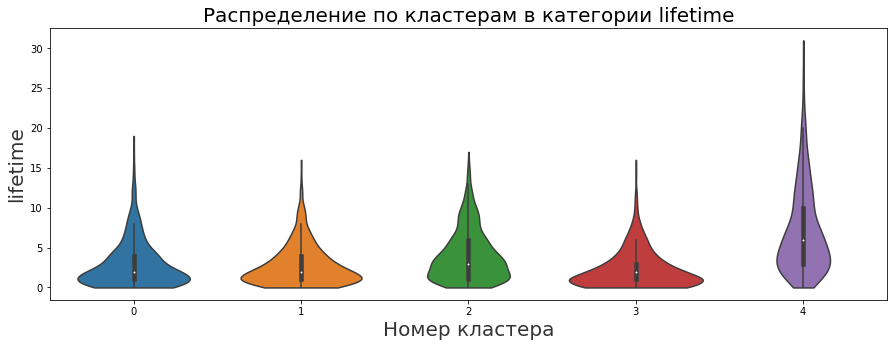

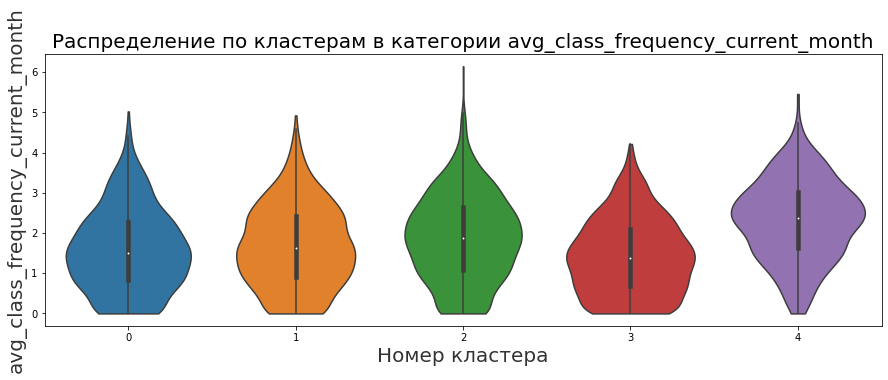

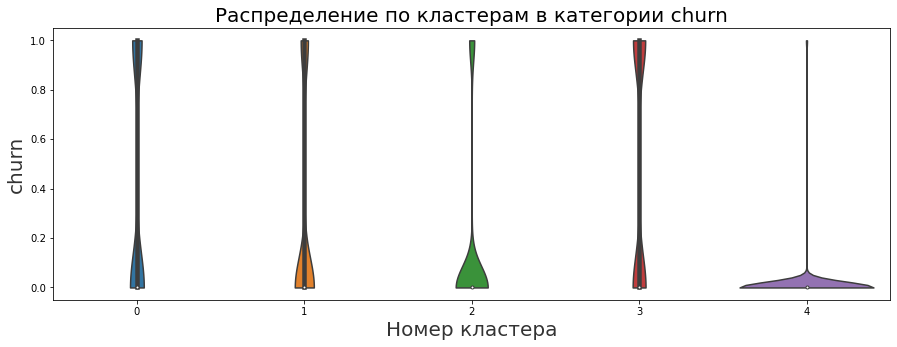

In [54]:
# Построим графики в цикле
for col in range(len(df_w.columns)-1):
    cat = list(df_w.columns)[col]
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.violinplot(x="cluster_km", y=cat,  data=df_w,cut = 0)
    ax.set_xlabel("Номер кластера",size = 20,alpha=0.8)
    ax.set_ylabel(cat,size = 20,alpha=0.8)
    ax.set_title(f'Распределение по кластерам в категории {cat}',size=20);

По графикам видно, что
<li>Клиенты из 0 кластера однозначно все не работают и не живут в районе фитнес центра. Это главная характеристика этого кластера.</li>
<li>Клиенты из 1 и 3-го кластера описываются одинаково по всех характеристикам, за исключением характеристики group_visits. Клиенты из 1 кластера посещают груповые занятия, а из 3 - нет. Кластер 1 храктеризуются главным образом двумя характеристиками: все клиенты из этого кластера живут или работают в районе фитнес центра и все посещают групповые занятия.</li> 
<li>Клиенты из 2-го кластера в основном проживают или работают в районе фитнес-центра, но главной характеристикой этого кластера является то, что все клиенты пришли по промо акции. </li>
<li>Клиенты из 3-го кластера абсолютно все живут или работают в районе фитнес-центра и посещают не посещают групповые занятия.
<li>Клиенты из 4-го кластера в основном характеризуются продолжительными контрактами и посещением фитнес-центра минимум 2 раза в неделю. Клиенты из этого кластера очень редко попадают в отток.</li>

Для каждого полученного кластера посчитаем долю оттока

In [55]:
# сгруппируем данные по кластерам 
df_cl = df_w.groupby('cluster_km').agg({'churn': ['sum', 'count']})
df_cl

churn      
             sum count
cluster_km            
0            245   606
1            195   712
2            136  1018
3            480   990
4              5   674

In [56]:
# изменим названия колонок
df_cl.columns = ['sum', 'count']

In [57]:
# добавим колонку с отношением sum/count
df_cl['ratio'] = df_cl['sum']*100/df_cl['count']

In [58]:
df_cl.sort_values(by='ratio', ascending=True)

,sum,count,ratio
cluster_km,,,
4,5,674,0.741840
2,136,1018,13.359528
1,195,712,27.387640
0,245,606,40.429043
3,480,990,48.484848


Самый низкий отток в 4 кластере - менее 1%. Во втором кластере отток составляет 13%. В первом - практически 30%. Самый высокий процент оттока в 0 и 3 кластерах: 40 и 48% соответственно. 

Таким образом 0 и 3 кластеры склонны к оттоку, а надежными являются 4 и 2 кластеры.

## Шаг 5. Выводы

Из проведенного анализа можно сделать выводы, что чаще всего в отток попадают клиенты, которые недавно пришли в фитнес-центр и заключили не продолжительные контракты (на месяц), редко посещают финтес-центр (менее 2х раз в неделю). Чаще всего это люди до 30 лет.

Из анализа кластеров мы определили, что самый большой отток из кластера 3 (48%). И этот кластер отличается от кластера 1, где отток ниже (27%) тем, что клиенты из кластера 1 посещают групповые занятия, а из кластера 3 - нет. 
Следовательно, необходимо усиленно предлагать новым клиентам групповые занятия.

Из кластера 0 тоже большой отток (40%), однако, этот кластер харатеризует удаленность клиентов от фитнес-центров (не живут и не работают в районе фитнес-центра). Здесь сложно понизить отток, однако, можно изучить работодателей этих клиентов и предложить им сотрудничество. Это поможет поддерживать привлекательность фитнес-центра.

Также, если клиент оформляет контракт только на месяц, то понятно, что клиент не уверен, что он будет продолжать ходить в фитнес-центр. Поэтому для такого клиента необходимо повысить привлекательность посещения фитнес-центра: второе посещение в неделю - бесплатно. После второго посещения - коктель бесплатно. Накопление скидки на следующий контракт на 6 или 12 месяцев за каждое посещение фитнес-центра за контрактный месяц.